In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from hw2 import get_mnist_threes_nines, display_image
%matplotlib inline

1.2a (finite differences checker, used to help implement `my_nn_finite_difference_checker` in 1.3a. Feel free to modify the function signature, or to skip this part and implement `my_nn_finite_difference_checker` without this helper function.)

In [2]:
def finite_difference_checker(f, x, k):
    """Returns \frac{\partial f}{\partial x_k}(x)"""
    # x is a list of 2d array and k is a tuple
    eps, i, j, h = 1e-5, k[0], k[1], k[2]
    x[i][j, h] += eps 
    f1 = f(x)
    x[i][j, h] -= 2*eps 
    f2 = f(x)
    return (f1-f2)/(2*eps)

1.2b (functions that implement neural network layers)

In [3]:
def sigmoid_activation(x):
    exp_pos = np.zeros(x.shape)
    np.exp(-x, out=exp_pos, where=(x>=0))
    out_pos = 1./(1+exp_pos)
    grad_pos = exp_pos/(1+exp_pos)**2
    
    exp_neg = np.zeros(x.shape)
    np.exp(x, out=exp_neg, where=(x<0))
    out_neg = exp_neg/(1+exp_neg)
    grad_neg = exp_neg/(1+exp_neg)**2
    
    out = np.where(x>=0, out_pos, out_neg)
    grad = np.where(x>=0, grad_pos, grad_neg)
    eps = 1e-15
    out = np.maximum(np.minimum(out, 1-eps), eps)
    return out, grad

def logistic_loss(g, y):
    """
    Computes the loss and gradient for binary classification with logistic
    loss

    Inputs:
    - g: Output of final layer with sigmoid activation,
         of shape (n, 1) 

    - y: Vector of labels, of shape (n,) where y[i] is the label for x[i] 
         and y[i] in {0, 1}

    Returns a tuple of:
    - loss: array of losses
    - dL_dg: Gradient of the loss with respect to g
    """
    y = y[:,None]
    loss = -np.log(np.where(y==1, g, 1-g))
    dL_dg = -1./np.where(y==1, g, g-1)
    return loss, dL_dg

def relu_activation(s):
    out = np.maximum(s, 0)
    ds = np.array(s>0, dtype=float)
    return out, ds

def layer_forward(x, W, b, activation_fn):
    # cache = (grad_of_activation_fn, weight_matrix, x^(l-1))
    n, _ = x.shape
    s = x@W + np.tile(b, (n, 1))
    out, cache = activation_fn(s)
    cache = (cache, W, x)
    return out, cache

1.3b i, ii (deliverables for the sigmoid activation)

In [4]:
# 1.3b i
s = np.asarray([1., 0., -1])
out, grad = sigmoid_activation(s)
with np.printoptions(precision=2):
    print(out)
    print(grad)
    
print("="*80)

# 1.3b ii
s = np.asarray([-1000., 1000.])
out, grad = sigmoid_activation(s)
print(out)
print(grad)

[0.73 0.5  0.27]
[0.2  0.25 0.2 ]
[1.e-15 1.e+00]
[0. 0.]


1.3b iii: What is the derivative of the negative log-likelihood loss with respect to $g$?

$\frac{dL}{dg} = -(\frac{1}{g})^y(\frac{1}{g-1})^{1-y}$

1.3b iv: Explain what is returned in `cache` in your `layer_forward` implementation. (Trying to answer this question before completing your implementation might help think about should go in `cache`, which should be stuff computed during the forward pass that is needed for backpropagation in the backward pass. Just make sure your final answer pertains to what you ultimately return in `cache`.)

Cache should be a tuple containing:
1. the derivative of the activation function
2. $W$, the $d^{(l-1)}\times d^{(l)}$ weight matrix for layer $l$ 
3. $x^{(l-1)}$, the input of layer $l$

The derivative of the activation function and $W$ will be later used to compute $\frac{dL}{ds^{(l)}}$ and $\frac{dL}{dx^{(l-1)}}$. $x^{(l-1)}$ will be used to compute $\frac{dL}{dW}$.

1.2c (in this part you will code functions that initialize the neural network's weights. You will also code the forward pass which ties everything together, computing the output of a neural network with weights given by `weight_matrices` + `biases`, activation functions given by `activations`, on the input `X_batch`, a 2d input where each row is an individual input vector)

In [5]:
def create_weight_matrices(layer_dims):
    """
    Creates a list of weight matrices defining the weights of NN
    
    Inputs:
    - layer_dims: A list whose size is the number of layers. layer_dims[i] defines
      the number of neurons in the i+1 layer.

    Returns a list of weight matrices
    """
    import random
    weights = []
    for i in range(1, len(layer_dims)):
        weight = np.random.normal(0., 0.01, (layer_dims[i-1], layer_dims[i]))
        weights.append(weight)
    return weights

def create_bias_vectors(layer_dims):
    import random
    biases = []
    for i in range(1, len(layer_dims)):
        bias = np.random.normal(0., 0.01, (1, layer_dims[i]))
        biases.append(bias)
    return biases

def forward_pass(X_batch, weight_matrices, biases, activations):
    x, layer_caches = X_batch, []
    for i in range(len(weight_matrices)):
        x, cache = layer_forward(x, weight_matrices[i], biases[i], activations[i])
        layer_caches.append(cache)
    return x, layer_caches

1.3c (deliverable which has you run a forward pass of your neural network and compute its logistic loss on some output)

In [6]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
output, _ = forward_pass(X_batch, weight_matrices, biases,
                         activations)
loss, dL_dg = logistic_loss(output, y_batch)
print(loss.mean())

0.6985168038536878


1.3a (deliverable which has you compute the gradient w.r.t. `weight_matrices` and `biases` using a finite differences checker)

In [7]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)
    
def my_nn_finite_difference_checker(X_batch, y_batch, weight_matrices, biases, activations):
    """
    Returns two lists of grads of weight matrices and biases
    each grad of weight matrix has shape (n, d^l-1, d^l)
    each grad of bias has shape (n, 1, d^l)
    """
    n = X_batch.shape[0]
    def f(x):
        output, _ = forward_pass(X_batch, x, biases, activations)
        loss, dL_dg = logistic_loss(output, y_batch)
        return loss
    grad_Ws = []
    for i in range(len(weight_matrices)):
        grad_Ws.append(np.ndarray((n, weight_matrices[i].shape[0], weight_matrices[i].shape[1]),dtype=float))
        for j in range(weight_matrices[i].shape[0]):
            for k in range(weight_matrices[i].shape[1]):
                grad_Ws[i][:, j, k] = finite_difference_checker(f, weight_matrices, (i, j, k))[:, 0]

    def f(x):
        output, _ = forward_pass(X_batch, weight_matrices, x, activations)
        loss, dL_dg = logistic_loss(output, y_batch)
        return loss
    grad_bs = []
    for i in range(len(biases)):
        grad_bs.append(np.ndarray((n, biases[i].shape[0], biases[i].shape[1]) ,dtype=float))
        for j in range(biases[i].shape[0]):
            for k in range(biases[i].shape[1]):
                grad_bs[i][:, j, k] = finite_difference_checker(f, biases, (i, j, k))[:, 0]
        
    return grad_Ws, grad_bs

grad_Ws, grad_bs = my_nn_finite_difference_checker(X_batch, 
                                                   y_batch, 
                                                   weight_matrices, 
                                                   biases, 
                                                   activations)   

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[[ 0.00e+00  1.06e-04]
  [ 0.00e+00  3.52e-05]
  [ 0.00e+00  4.25e-05]
  [ 0.00e+00  1.87e-05]]

 [[ 8.23e-04 -3.92e-05]
  [-1.31e-04  6.25e-06]
  [-2.48e-03  1.18e-04]
  [ 4.52e-04 -2.15e-05]]]

[[[ 0.  ]
  [-0.  ]]

 [[-0.  ]
  [-0.01]]]

[[[ 0.  0.]]

 [[-0.  0.]]]

[[[-0.5]]

 [[-0.5]]]


1.2d (the backward pass!!!!)

In [8]:
def backward_pass(dL_dg, layer_caches):
    """
    Returns two lists of grads of weight matrices and biases
    each grad of weight matrix has shape (n, d^l-1, d^l)
    each grad of bias has shape (n, 1, d^l)
    """
    # cache = (grad_of_activation_fn, weight_matrix, x^(l-1))
    dL_dx = dL_dg
    grad_Ws, grad_bs = [], []
    for i in range(len(layer_caches)-1,-1,-1):
        dL_ds = dL_dx*layer_caches[i][0]
        dL_dx = dL_ds@layer_caches[i][1].T
        grad_Ws.append(np.einsum("hj,hi->hij", dL_ds, layer_caches[i][2]))
        grad_bs.append(dL_ds[:, None, :])
    return grad_Ws[::-1], grad_bs[::-1]

1.3d (test your backward pass! compare it with 1.3a, the gradient computed by the finite difference checker. The answers should match!)

In [9]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
output, layer_caches = forward_pass(X_batch, weight_matrices, biases,
                                    activations)
loss, dL_dg = logistic_loss(output, y_batch)
grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[[ 0.00e+00  1.06e-04]
  [ 0.00e+00  3.52e-05]
  [ 0.00e+00  4.25e-05]
  [ 0.00e+00  1.87e-05]]

 [[ 8.23e-04 -3.92e-05]
  [-1.31e-04  6.25e-06]
  [-2.48e-03  1.18e-04]
  [ 4.52e-04 -2.15e-05]]]

[[[ 0.  ]
  [-0.  ]]

 [[-0.  ]
  [-0.01]]]

[[[-0.  0.]]

 [[-0.  0.]]]

[[[-0.5]]

 [[-0.5]]]


1.2e (train your neural network on MNIST! save the training and test losses and accuracies at each iteration to use in 1.3e)

In [10]:
(X_train, y_train), (X_test, y_test) = get_mnist_threes_nines()
tot_train, tot_test = X_train.shape[0], X_test.shape[0]
X_train, X_test = X_train.reshape((tot_train, -1)), X_test.reshape((tot_test, -1))

num_epoch, batch_size, step_size = 5, 100, 0.1
layer_dims = [784, 200, 1]
activations = [relu_activation, sigmoid_activation]
weight_matrices, biases = create_weight_matrices(layer_dims), create_bias_vectors(layer_dims)

training_loss, training_acc, test_loss, test_acc = [], [], [], []

random_perm = np.arange(tot_train)
for i in range(num_epoch):
    # reshuffle training data for each epoch
    np.random.shuffle(random_perm)
    X_train, y_train = X_train[random_perm], y_train[random_perm]
    
    for j in range(0, tot_train, batch_size):
        X_batch, y_batch = X_train[j:min(j+batch_size, tot_train)], y_train[j:min(j+batch_size, tot_train)]
        output, layer_caches = forward_pass(X_batch, weight_matrices, biases, activations)
        loss, dL_dg = logistic_loss(output, y_batch)
        grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)
        
        # update weights and biases
        for k in range(len(weight_matrices)):
            weight_matrices[k] -= step_size*np.mean(grad_Ws[k], axis=0)
            biases[k] -= step_size*np.mean(grad_bs[k], axis=0)
        
        # compute training loss and accuracy
        n = min(j+batch_size, tot_train)-j
        training_loss.append(loss.mean())
        training_acc.append(np.sum(np.array((output[:, 0]>0.5)==y_batch, dtype=float))/n)
        # compute test loss and accuracy
        output, _ = forward_pass(X_test, weight_matrices, biases, activations)
        loss, _ = logistic_loss(output, y_test)
        test_loss.append(loss.mean())
        test_acc.append(np.sum(np.array((output[:, 0]>0.5)==y_test, dtype=float))/tot_test)

In [11]:
print("test accuracy: {}".format(test_acc[-1]))

test accuracy: 0.9831599801882119


1.3e code answers for i, ii, iii

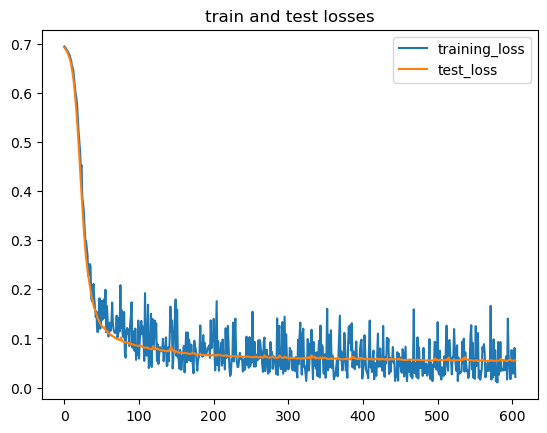

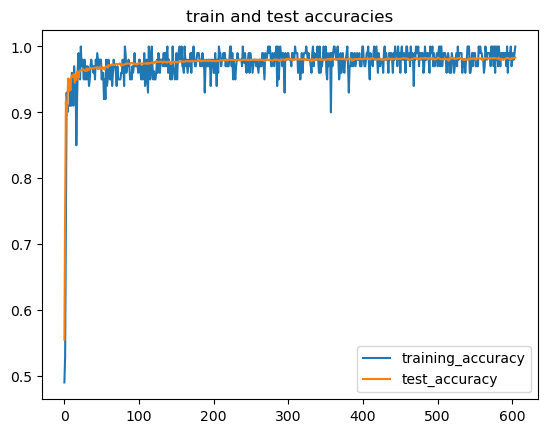

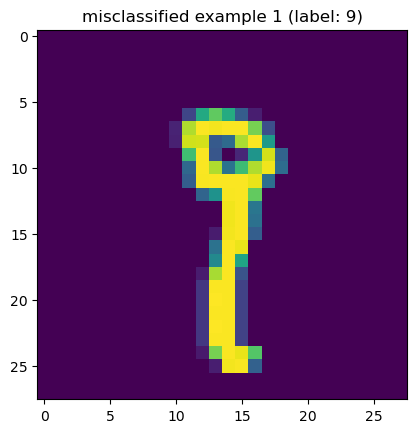

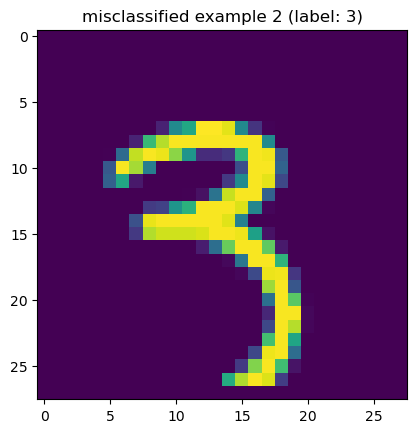

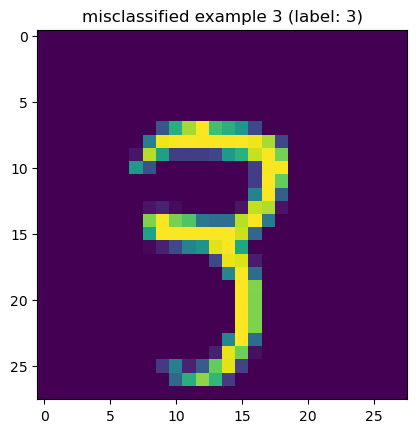

In [12]:
# i
# Plot the train and test losses from the MNIST network with step size = 0.1
x_time = np.arange(len(test_loss))
plt.title("train and test losses")
plt.plot(x_time, training_loss, label='training_loss')
plt.plot(x_time, test_loss, label='test_loss')
plt.legend()
plt.show()

# ii
# Plot the train and test accuracies from the MNIST network with step size = 0.1
plt.title("train and test accuracies")
plt.plot(x_time, training_acc, label='training_accuracy')
plt.plot(x_time, test_acc, label='test_accuracy')
plt.legend()
plt.show()

# iii
# Visualize (plot) some images that are misclassified by your network
id_miss = np.nonzero((output[:, 0]>0.5)!=y_test)[0]
for i in range(3):
    plt.title("misclassified example {} (label: {})".format(i+1, 9 if y_test[id_miss[i]]==1 else 3))
    plt.imshow(X_test[id_miss[i]].reshape((28, 28)))
    plt.show()

1.3e iii:
Examine the images that your network guesses incorrectly, and explain at a high level
what patterns you see in those images.

Misclassified example 1: it is not a typical 9. The circle in the upper half of 9 is too small. Also the circle is too centered instead of being to the left of the vertical line in the lower half of 9.

Misclassified example 2&3: the same pattern occurs in these two images where the semicircle in the upper half of 3 looks like a whole circle and the semicircle in the lower half of 3 looks like a vertical line. This pattern matches the characteristic of 9 so is misclassified. 

1.3e iv:
Rerun the neural network training but now increase the step size to 10.0. What happens?
You do not need to include plots here.

The accuracy drops signaficantly. After a few time steps, the test accuracy stabilized at around 50% and the accuracy across the training mini-batch fluctuated around 50%. Since the step size 10.0 is too larger, every time we update the weight by adding gradient to it, it jumps out of the local minimum to somewhere far away. After several iterations, the weights and biases become either too larger or too small, and the output of the neural network becomes either all $10^{-15}$s or all $1.0$s, predicting the images to be either all 3s or all 9s. 

After the output becomes either all $10^{-15}$s or all $1.0$s, the model would remain stable since the gradient in this case would be extremely close to 0. 

1.3f (optional) (Train a network to fit 100 random images to the first 100 original labels! How fast can you memorize the dataset?)

In [13]:
X_train = np.random.rand(100, 784)
# YOUR CODE HERE